In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def split_dataset_60_20_20(data, random_state=42):
    """
    Split dataset into training (70%), validation (20%), and test (10%) sets
    
    Parameters:
    data: pandas DataFrame
    random_state: int, for reproducibility
    
    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    # Separate features and labels
    X = data.drop('class', axis=1).values
    y = pd.get_dummies(data['class']).values
    
    # First split: 90% train+val, 10% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=0.5, 
        random_state=random_state
    )
    
    # Second split: 70% train, 20% validation (0.25 of remaining 80%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, 
        test_size=0.1, 
        random_state=random_state
    )
    
    # Initialize and fit scaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # Transform validation and test sets
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Reshape for RNN (samples, time steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load the dataset
data = pd.read_csv('extracted_features_500.csv')

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset_70_20_10(data)

# Print the shapes of all sets
print("\nDataset Split (60-20-20):")
print(f"Training set (60%):")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nValidation set (20%):")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"\nTest set (20%):")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Print class distribution in each set
print("\nClass distribution in each set:")
print("\nTraining set:")
print(pd.DataFrame(y_train).sum(axis=0))
print("\nValidation set:")
print(pd.DataFrame(y_val).sum(axis=0))
print("\nTest set:")
print(pd.DataFrame(y_test).sum(axis=0))


Dataset Split (60-20-20):
Training set (60%):
X_train shape: (360, 12, 1)
y_train shape: (360, 5)

Validation set (20%):
X_val shape: (90, 12, 1)
y_val shape: (90, 5)

Test set (20%):
X_test shape: (50, 12, 1)
y_test shape: (50, 5)

Class distribution in each set:

Training set:
0    67
1    74
2    78
3    69
4    72
dtype: int64

Validation set:
0    18
1    19
2    19
3    19
4    15
dtype: int64

Test set:
0    15
1     7
2     3
3    12
4    13
dtype: int64


In [22]:
import time
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Use softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Function to get model size in MB
def get_model_size(model):
    model.save("temp_model.h5")
    model_size = os.path.getsize("temp_model.h5") / (1024 ** 2)  # size in MB
    os.remove("temp_model.h5")
    return model_size

# Track training time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Calculate training time
end_time = time.time()
training_time = end_time - start_time

# Get model size in MB
model_size = get_model_size(model)

print(f"Model Size: {model_size:.2f} MB")
print(f"Training Time: {training_time:.2f} seconds")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)            │ (None, 12, 100)             │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 12, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,805 (120.33 KB)

 Trainable params: 30,805 (120.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4172 - loss: 1.3510 - val_accuracy: 0.6222 - val_loss: 0.9806
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6633 - loss: 0.8185 - val_accuracy: 0.6222 - val_loss: 0.9037
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7152 - loss: 0.6984 - val_accuracy: 0.6333 - val_loss: 0.8213
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7299 - loss: 0.7020 - val_accuracy: 0.6778 - val_loss: 0.8110
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7881 - loss: 0.6117 - val_accuracy: 0.6778 - val_loss: 0.8083
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7670 - loss: 0.5831 - val_accuracy: 0.6667 - val_loss: 0.7601
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8230 - loss: 0.5316 - val_accuracy: 0.6889 - val_loss: 0.7991
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7378 - loss: 0.6324 - val_accuracy: 0.7222 - 

Model Size: 0.39 MB
Training Time: 13.58 seconds


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Mean Squared Error (MSE): 0.5600
Mean Absolute Error (MAE): 0.2800
Root Mean Squared Error (RMSE): 0.7483


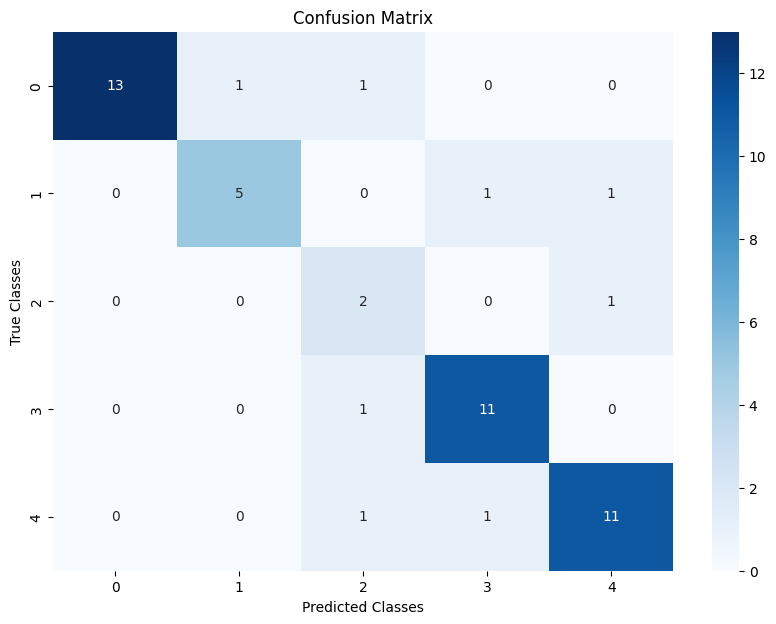

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.83      0.71      0.77         7
           2       0.40      0.67      0.50         3
           3       0.85      0.92      0.88        12
           4       0.85      0.85      0.85        13

    accuracy                           0.84        50
   macro avg       0.79      0.80      0.78        50
weighted avg       0.86      0.84      0.85        50



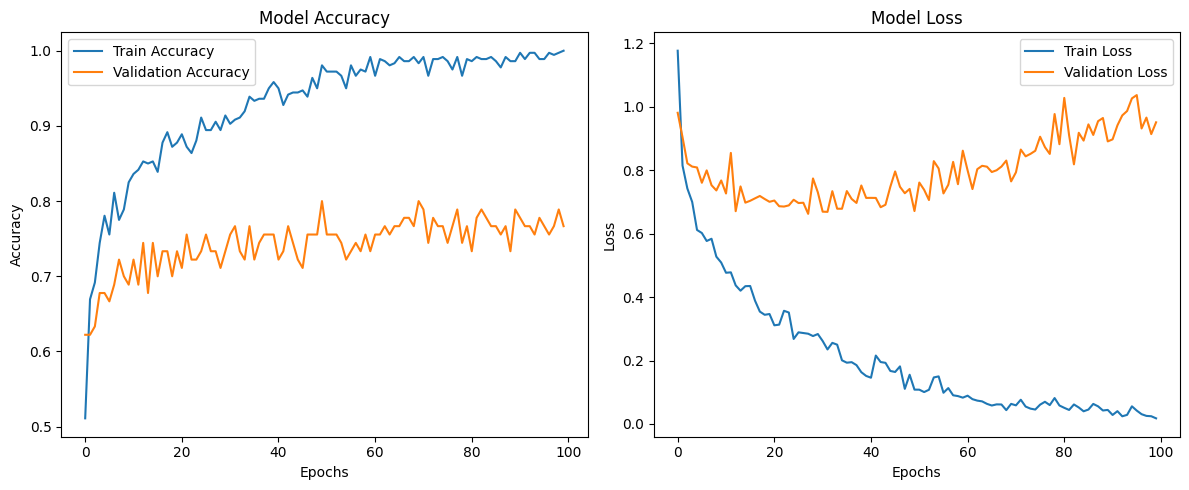

In [28]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_classes, predicted_classes)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_classes, predicted_classes)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_classes), yticklabels=np.unique(true_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(true_classes, predicted_classes))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming y_test is your true labels (one-hot encoded) and y_pred contains predicted probabilities
# Convert predicted probabilities to class labels
predicted_classes = np.argmax(y_pred, axis=1)  # Predicted class indices
true_classes = np.argmax(y_test, axis=1)       # True class indices

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_classes, predicted_classes)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_classes, predicted_classes)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.5600
Mean Absolute Error (MAE): 0.2800
Root Mean Squared Error (RMSE): 0.7483
